# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter.

In [1]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/assignment3"
if not os.path.exists(datadir):
  !ln -s "/content/drive/My Drive/assignment3_starter_sp25" $datadir # TODO: Fill your assignment3 path
os.chdir(datadir)
!pwd

/content/drive/My Drive/assignment3_starter_sp25


# Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random


def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    # TODO: Implement rotate_img() - return the rotated img
    #
    #
    #
    return torch.rot90(img, k=rot, dims=(1, 2))

    # else:
    #    raise ValueError('rotation should be 0, 90, 180, or 270 degrees')

class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Show some example images and rotated images with labels:

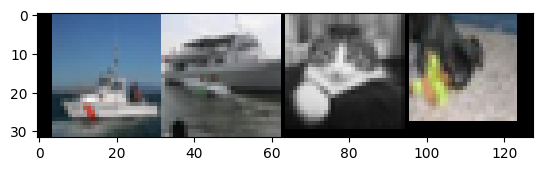

Class labels:  ship  ship  cat   dog  


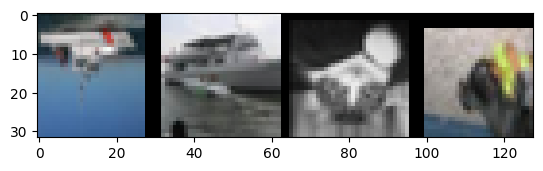

Rotation labels:  180   0     180   180  


In [5]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Evaluation code

In [6]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            #
            #
            #
            outputs = net(images)
            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
            probabilities, classes = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (classes == labels).sum().item()
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')



In [7]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


## 1. Train a ResNet18 on the rotation task

In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [10]:
import torch.optim as optim

# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [11]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)


            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            #
            if task == 'rotation':
              images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
              images, labels = imgs.to(device), cls_label.to(device)

            # TODO: Zero the parameter gradients
            #
            optimizer.zero_grad()

            # TODO: forward + backward + optimize
            #
            #
            #
            #
            #
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # TODO: Get predicted results
            _, predicted = torch.max(outputs, 1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        #
        #
        net.eval()
        run_test(net, testloader, criterion, task)
    print(init_lr * (0.1 ** (num_epochs // decay_epochs)))
    print('Finished Training')

In [ ]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')


# TODO: Save the model
#
PATH = './rotationResNet18.pth'
torch.save(net.state_dict(), PATH)


[1,   100] loss: 1.442 acc: 35.67 time: 5.58
[1,   200] loss: 1.221 acc: 44.86 time: 6.65
[1,   300] loss: 1.229 acc: 45.12 time: 5.20
TESTING:
Accuracy of the network on the 10000 test images: 50.81 %
Average loss on the 10000 test images: 1.126
[2,   100] loss: 1.168 acc: 48.41 time: 5.35
[2,   200] loss: 1.154 acc: 49.69 time: 6.55
[2,   300] loss: 1.103 acc: 52.35 time: 5.16
TESTING:
Accuracy of the network on the 10000 test images: 54.11 %
Average loss on the 10000 test images: 1.057
[3,   100] loss: 1.058 acc: 54.40 time: 5.38
[3,   200] loss: 1.050 acc: 55.23 time: 6.02
[3,   300] loss: 1.041 acc: 55.91 time: 5.64
TESTING:
Accuracy of the network on the 10000 test images: 57.63 %
Average loss on the 10000 test images: 1.030
[4,   100] loss: 1.017 acc: 56.70 time: 5.64
[4,   200] loss: 1.002 acc: 57.80 time: 5.42
[4,   300] loss: 1.000 acc: 57.34 time: 6.45
TESTING:
Accuracy of the network on the 10000 test images: 59.40 %
Average loss on the 10000 test images: 0.989
[5,   100] l

## 2.1 Fine-tuning on the pre-trained model

In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
#
#
#
net = resnet18(num_classes=10)
net = net.to(device)
net_dict = net.state_dict()


pretrained = resnet18(num_classes = 4)
PATH = './rotationResNet18.pth'
pretrained.load_state_dict(torch.load(PATH))
pretrained_dict = pretrained.state_dict()

for k, v in pretrained_dict.items():
  if not (k.startswith("layer4") or k.startswith("fc")):
    net_dict[k] = v
net.load_state_dict(net_dict)




<All keys matched successfully>

In [ ]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
#
#
#
#
for param in net.parameters():
    param.requires_grad = False
for param in net.fc.parameters():
    param.requires_grad = True
for name, param in net.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [ ]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')
PATH = './fineTunedPreTrained.pth'
torch.save(net.state_dict(), PATH)

[1,   100] loss: 2.002 acc: 31.79 time: 6.83
[1,   200] loss: 1.634 acc: 40.16 time: 5.16
[1,   300] loss: 1.533 acc: 44.01 time: 6.07
TESTING:
Accuracy of the network on the 10000 test images: 47.57 %
Average loss on the 10000 test images: 1.447
[2,   100] loss: 1.463 acc: 46.76 time: 6.34
[2,   200] loss: 1.410 acc: 48.38 time: 5.11
[2,   300] loss: 1.407 acc: 48.91 time: 6.43
TESTING:
Accuracy of the network on the 10000 test images: 49.77 %
Average loss on the 10000 test images: 1.378
[3,   100] loss: 1.371 acc: 49.91 time: 6.55
[3,   200] loss: 1.374 acc: 49.86 time: 4.97
[3,   300] loss: 1.366 acc: 50.48 time: 5.68
TESTING:
Accuracy of the network on the 10000 test images: 50.55 %
Average loss on the 10000 test images: 1.363
[4,   100] loss: 1.342 acc: 51.41 time: 6.04
[4,   200] loss: 1.324 acc: 51.99 time: 6.01
[4,   300] loss: 1.349 acc: 51.36 time: 5.53
TESTING:
Accuracy of the network on the 10000 test images: 52.81 %
Average loss on the 10000 test images: 1.311
[5,   100] l

## 2.2 Fine-tuning on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
#
#
#
net = resnet18(num_classes=10)
net = net.to(device)

In [ ]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# To do this, you should set requires_grad=False for the frozen layers.
#
#
#
for param in net.parameters():
    param.requires_grad = False
for param in net.fc.parameters():
    param.requires_grad = True
for name, param in net.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
        if name == 'layer4.0.conv1.weight':
          print(param.shape)

Params to learn:
	 layer4.0.conv1.weight
torch.Size([512, 256, 3, 3])
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [ ]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')
PATH = './fineTunedRandom.pth'
torch.save(net.state_dict(), PATH)

[1,   100] loss: 2.258 acc: 24.48 time: 5.06
[1,   200] loss: 1.945 acc: 29.96 time: 5.49
[1,   300] loss: 1.879 acc: 31.75 time: 5.71
TESTING:
Accuracy of the network on the 10000 test images: 37.28 %
Average loss on the 10000 test images: 1.733
[2,   100] loss: 1.817 acc: 33.82 time: 5.97
[2,   200] loss: 1.787 acc: 35.10 time: 4.82
[2,   300] loss: 1.774 acc: 35.65 time: 6.42
TESTING:
Accuracy of the network on the 10000 test images: 39.48 %
Average loss on the 10000 test images: 1.674
[3,   100] loss: 1.757 acc: 36.18 time: 6.61
[3,   200] loss: 1.762 acc: 36.41 time: 4.90
[3,   300] loss: 1.745 acc: 36.05 time: 4.98
TESTING:
Accuracy of the network on the 10000 test images: 39.33 %
Average loss on the 10000 test images: 1.677
[4,   100] loss: 1.726 acc: 37.62 time: 5.12
[4,   200] loss: 1.737 acc: 36.69 time: 6.12
[4,   300] loss: 1.707 acc: 38.35 time: 4.86
TESTING:
Accuracy of the network on the 10000 test images: 40.56 %
Average loss on the 10000 test images: 1.649
[5,   100] l

## 3.1 Supervised training on the pre-trained model
In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
#
#
#
net = resnet18(num_classes=10)
net = net.to(device)
net_dict = net.state_dict()


pretrained = resnet18(num_classes = 4)
PATH = './rotationResNet18.pth'
pretrained.load_state_dict(torch.load(PATH))
pretrained_dict = pretrained.state_dict()

for k, v in pretrained_dict.items():
  print(k)
  if not (k.startswith("fc")):
    net_dict[k] = v
net.load_state_dict(net_dict)

conv1.weight
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.bn1.running_mean
layer1.0.bn1.running_var
layer1.0.bn1.num_batches_tracked
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.bn2.running_mean
layer1.0.bn2.running_var
layer1.0.bn2.num_batches_tracked
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.bn1.running_mean
layer1.1.bn1.running_var
layer1.1.bn1.num_batches_tracked
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.bn2.running_mean
layer1.1.bn2.running_var
layer1.1.bn2.num_batches_tracked
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.bn1.running_mean
layer2.0.bn1.running_var
layer2.0.bn1.num_batches_tracked
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.bn2.running_mean
layer2.0.bn2.running_var
layer2.0.bn2.num_batches_tracked
layer2.0.downsample.0.weight
layer2.0.downsamp

<All keys matched successfully>

In [ ]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')
PATH = './preTrainedFullNetwork.pth'
torch.save(net.state_dict(), PATH)

[1,   100] loss: 1.737 acc: 41.59 time: 6.38
[1,   200] loss: 1.321 acc: 53.89 time: 5.78
[1,   300] loss: 1.159 acc: 59.86 time: 5.21
TESTING:
Accuracy of the network on the 10000 test images: 61.92 %
Average loss on the 10000 test images: 1.136
[2,   100] loss: 1.084 acc: 62.47 time: 5.37
[2,   200] loss: 0.989 acc: 65.55 time: 6.62
[2,   300] loss: 0.969 acc: 66.52 time: 5.19
TESTING:
Accuracy of the network on the 10000 test images: 69.68 %
Average loss on the 10000 test images: 0.867
[3,   100] loss: 0.876 acc: 69.15 time: 5.51
[3,   200] loss: 0.894 acc: 69.10 time: 6.88
[3,   300] loss: 0.878 acc: 69.73 time: 5.29
TESTING:
Accuracy of the network on the 10000 test images: 72.50 %
Average loss on the 10000 test images: 0.809
[4,   100] loss: 0.809 acc: 71.97 time: 5.80
[4,   200] loss: 0.788 acc: 72.43 time: 6.57
[4,   300] loss: 0.782 acc: 72.73 time: 5.38
TESTING:
Accuracy of the network on the 10000 test images: 74.04 %
Average loss on the 10000 test images: 0.745
[5,   100] l

## 3.2 Supervised training on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
#
#
#
net = resnet18(num_classes=10)
net = net.to(device)


In [ ]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')
PATH = './randomFullNetwork.pth'
torch.save(net.state_dict(), PATH)

[1,   100] loss: 2.313 acc: 21.34 time: 7.04
[1,   200] loss: 1.892 acc: 31.24 time: 6.64
[1,   300] loss: 1.780 acc: 34.88 time: 5.27
TESTING:
Accuracy of the network on the 10000 test images: 41.99 %
Average loss on the 10000 test images: 1.594
[2,   100] loss: 1.600 acc: 41.61 time: 5.48
[2,   200] loss: 1.529 acc: 43.46 time: 7.08
[2,   300] loss: 1.460 acc: 46.48 time: 5.69
TESTING:
Accuracy of the network on the 10000 test images: 52.25 %
Average loss on the 10000 test images: 1.347
[3,   100] loss: 1.353 acc: 49.91 time: 5.89
[3,   200] loss: 1.299 acc: 52.57 time: 6.66
[3,   300] loss: 1.234 acc: 55.38 time: 5.48
TESTING:
Accuracy of the network on the 10000 test images: 58.09 %
Average loss on the 10000 test images: 1.189
[4,   100] loss: 1.127 acc: 59.52 time: 5.60
[4,   200] loss: 1.118 acc: 59.89 time: 6.97
[4,   300] loss: 1.078 acc: 61.67 time: 5.48
TESTING:
Accuracy of the network on the 10000 test images: 64.32 %
Average loss on the 10000 test images: 0.995
[5,   100] l

## 4 Improvements on Rotation and Classification



In [ ]:
#trying to see the dimensions
resnet18model = resnet18(num_classes = 4)
print(resnet18model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
class ModifiedResNet18(nn.Module):
    def __init__(self, num_classes=4):
        super(ModifiedResNet18, self).__init__()
        self.pre_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )


        self.resnet = resnet18()
        self.resnet.conv1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)


        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.pre_conv(x)
        x = self.resnet(x)
        return x

In [13]:
net = ModifiedResNet18(num_classes=4)
net = net.to(device)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [15]:
PATH = './ModifiedResNet18.pth'

train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')

# TODO: Save the model
#

torch.save(net.state_dict(), PATH)

[1,   100] loss: 1.519 acc: 25.63 time: 8.04
[1,   200] loss: 1.385 acc: 25.48 time: 6.08
[1,   300] loss: 1.376 acc: 26.48 time: 6.84
TESTING:
Accuracy of the network on the 10000 test images: 38.98 %
Average loss on the 10000 test images: 1.243
[2,   100] loss: 1.275 acc: 38.49 time: 5.97
[2,   200] loss: 1.242 acc: 41.36 time: 7.54
[2,   300] loss: 1.193 acc: 46.33 time: 5.99
TESTING:
Accuracy of the network on the 10000 test images: 51.78 %
Average loss on the 10000 test images: 1.115
[3,   100] loss: 1.153 acc: 49.59 time: 6.05
[3,   200] loss: 1.146 acc: 50.12 time: 7.13
[3,   300] loss: 1.131 acc: 51.24 time: 6.02
TESTING:
Accuracy of the network on the 10000 test images: 53.89 %
Average loss on the 10000 test images: 1.064
[4,   100] loss: 1.103 acc: 53.19 time: 7.27
[4,   200] loss: 1.099 acc: 53.43 time: 6.08
[4,   300] loss: 1.094 acc: 53.88 time: 6.93
TESTING:
Accuracy of the network on the 10000 test images: 55.25 %
Average loss on the 10000 test images: 1.053
[5,   100] l

In [ ]:
for name, _ in net.state_dict().items():
    print(name)

pre_conv.0.weight
pre_conv.0.bias
pre_conv.1.weight
pre_conv.1.bias
pre_conv.1.running_mean
pre_conv.1.running_var
pre_conv.1.num_batches_tracked
resnet.conv1.weight
resnet.bn1.weight
resnet.bn1.bias
resnet.bn1.running_mean
resnet.bn1.running_var
resnet.bn1.num_batches_tracked
resnet.layer1.0.conv1.weight
resnet.layer1.0.bn1.weight
resnet.layer1.0.bn1.bias
resnet.layer1.0.bn1.running_mean
resnet.layer1.0.bn1.running_var
resnet.layer1.0.bn1.num_batches_tracked
resnet.layer1.0.conv2.weight
resnet.layer1.0.bn2.weight
resnet.layer1.0.bn2.bias
resnet.layer1.0.bn2.running_mean
resnet.layer1.0.bn2.running_var
resnet.layer1.0.bn2.num_batches_tracked
resnet.layer1.1.conv1.weight
resnet.layer1.1.bn1.weight
resnet.layer1.1.bn1.bias
resnet.layer1.1.bn1.running_mean
resnet.layer1.1.bn1.running_var
resnet.layer1.1.bn1.num_batches_tracked
resnet.layer1.1.conv2.weight
resnet.layer1.1.bn2.weight
resnet.layer1.1.bn2.bias
resnet.layer1.1.bn2.running_mean
resnet.layer1.1.bn2.running_var
resnet.layer1.1.bn

In [ ]:
classificationNet = ModifiedResNet18(num_classes=10)
classification_dict = classificationNet.state_dict()
classificationNet = classificationNet.to(device)


pretrained = ModifiedResNet18(num_classes = 4)
PATH = './ModifiedResNet18.pth'
pretrained.load_state_dict(torch.load(PATH))
pretrained_dict = pretrained.state_dict()

for k, v in pretrained_dict.items():
  if not (k.startswith("resnet.fc.3")):
    classification_dict[k] = v

classificationNet.load_state_dict(classification_dict)



<All keys matched successfully>

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classificationNet.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [ ]:
PATH = './ModifiedResNet18Classification.pth'

train(classificationNet, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='classification')

# TODO: Save the model
#

torch.save(classificationNet.state_dict(), PATH)

[1,   100] loss: 1.702 acc: 33.24 time: 7.19
[1,   200] loss: 1.394 acc: 45.09 time: 6.32
[1,   300] loss: 1.271 acc: 51.23 time: 6.83
TESTING:
Accuracy of the network on the 10000 test images: 60.10 %
Average loss on the 10000 test images: 1.204
[2,   100] loss: 1.082 acc: 62.64 time: 7.44
[2,   200] loss: 1.017 acc: 65.79 time: 6.13
[2,   300] loss: 0.969 acc: 67.60 time: 7.38
TESTING:
Accuracy of the network on the 10000 test images: 69.73 %
Average loss on the 10000 test images: 0.899
[3,   100] loss: 0.890 acc: 70.46 time: 7.62
[3,   200] loss: 0.876 acc: 70.95 time: 6.16
[3,   300] loss: 0.824 acc: 73.00 time: 7.24
TESTING:
Accuracy of the network on the 10000 test images: 74.38 %
Average loss on the 10000 test images: 0.793
[4,   100] loss: 0.779 acc: 74.88 time: 6.64
[4,   200] loss: 0.772 acc: 75.45 time: 6.82
[4,   300] loss: 0.749 acc: 76.12 time: 6.59
TESTING:
Accuracy of the network on the 10000 test images: 77.95 %
Average loss on the 10000 test images: 0.693
[5,   100] l